# E3: Per-Fact Question Coverage Extension

**Research Question:** Does AskQE miss translation errors because some atomic facts are not explicitly probed?

**What E3 changes:** Instead of generating N questions from M facts in one LLM call, E3 generates exactly 1 question per fact (M questions from M facts). This guarantees 100% fact coverage.

**Dataset:** CONTRATICO EN-ES and EN-FR (synthetic perturbations, 4 types)


## 0. Setup

In [ ]:
# Cell [2]: GPU check
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat Feb 14 16:08:55 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             49W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [40]:
# Cell [3]: Install dependencies
!pip install "transformers>=4.52,<5.0" groq deep_translator sacrebleu bert_score sentence-transformers matplotlib

In [41]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [42]:
import os
os.environ["HF_HOME"] = "/content/drive/MyDrive/hf_cache"

In [44]:
import os
os.environ["GROQ_API_KEY"] = ""

In [45]:
# Cell [7]: Clone repo
# Clone repo into Drive (persists across sessions)
# If already cloned, this will just print an error — that's fine
!git clone https://github.com/AlessandroMaini/CucumBERT_askqe.git -b fact-coverage /content/drive/MyDrive/CucumBERT_askqe 2>/dev/null || echo "Repo already exists in Drive — reusing."
REPO_ROOT = "/content/drive/MyDrive/CucumBERT_askqe"
print(f"REPO_ROOT = {REPO_ROOT}")

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Repo already exists in Drive — reusing.
REPO_ROOT = /content/drive/MyDrive/CucumBERT_askqe


In [46]:
# Cell [8]: Set working directory
import os

os.chdir("/content/drive/MyDrive/CucumBERT_askqe")
print("Current dir:", os.getcwd())


Current dir: /content/drive/MyDrive/CucumBERT_askqe


In [75]:
# Cell [11]: Constants
import json
import numpy as np
from collections import defaultdict
LANGUAGES = ["es", "fr"]

PERTURBATIONS = ["synonym", "expansion_noimpact", "omission", "alteration"]

MINOR = ["synonym", "expansion_noimpact"]
CRITICAL = ["omission", "alteration"]


## 0b. Fact Extraction + Entailment (ONE-TIME)

Extract atomic facts from English source sentences and filter by entailment. **skip this section if files were already generated**.

Pipeline: `en-es.jsonl` → fact extraction (Groq) → `atomic_facts.jsonl` → entailment filter  → `entailed_facts.jsonl`

In [50]:

# Check if entailed_facts.jsonl already exists
facts_path = os.path.join(REPO_ROOT, "QG", "entailed_facts.jsonl")
SKIP_FACT_EXTRACTION = False

if os.path.exists(facts_path):
    count = sum(1 for _ in open(facts_path))
    print(f" entailed_facts.jsonl already exists ({count} instances) — SKIPPING.")
    print("  Delete the file and re-run this cell if you want to regenerate.")
    SKIP_FACT_EXTRACTION = True
else:
    print("✗ entailed_facts.jsonl not found — will run fact extraction + entailment.")
    SKIP_FACT_EXTRACTION = False

 entailed_facts.jsonl already exists (500 instances) — SKIPPING.
  Delete the file and re-run this cell if you want to regenerate.


In [51]:
# Step 1: Extract atomic facts from source sentences using Groq API
if not SKIP_FACT_EXTRACTION:
    os.chdir(os.path.join(REPO_ROOT, "QG", "fact-extraction"))
    !python extract_facts_groq.py --input_file "data/processed/en-es.jsonl"
else:
    print("Skipped — using existing facts.")

Skipped — using existing facts.


In [52]:
# Step 2: Filter to entailed facts only
if not SKIP_FACT_EXTRACTION:
    os.chdir(os.path.join(REPO_ROOT, "QG", "fact-extraction"))
    !python entail_facts.py --input_file "QG/atomic_facts.jsonl" --threshold 0.9
else:
    print("Skipped — using existing entailed facts.")

Skipped — using existing entailed facts.


In [53]:
# Verify fact extraction stats
import json
import numpy as np

facts_file = os.path.join(REPO_ROOT, "QG", "entailed_facts.jsonl")
total_atomic, total_entailed, n = 0, 0, 0

with open(facts_file) as f:
    for line in f:
        rec = json.loads(line)
        n += 1
        # Parse atomic_facts (may be JSON string)
        raw = rec.get("atomic_facts", "[]")
        facts = json.loads(raw) if isinstance(raw, str) else raw
        total_atomic += len(facts)

print(f"Instances: {n}")
print(f"Avg atomic/entailed facts per instance: {total_atomic/n:.2f}")
print(f"Paper reference (Llama-3 70B): 3.61 atomic → 3.08 entailed")

Instances: 500
Avg atomic/entailed facts per instance: 2.94
Paper reference (Llama-3 70B): 3.61 atomic → 3.08 entailed


## 1. Measure Baseline Fact Coverage (CRITICAL FIRST STEP)

Before running E3, we must quantify the problem: what fraction of entailed facts does the baseline already cover? If coverage is >95%, E3 has limited room to improve. If 70-80%, there's a real gap.

We use SBERT cosine similarity between each fact and each baseline question. A fact is "covered" if at least one question has similarity ≥ 0.7.

In [54]:
# Cell [18]: Load SBERT for coverage
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [55]:
# Cell [19]: Generate baseline questions
# Generate baseline (atomic) questions — needed for coverage analysis
# If   these files already exist , you can skip this cell.

import os, shutil, gc, torch

os.chdir(os.path.join(REPO_ROOT, "QG", "code"))

from qg_qwen3_4b import QuestionGenerator
qg_engine = QuestionGenerator(model_id="Qwen/Qwen3-4B-Instruct-2507")

INPUT_FILE = "QG/entailed_facts.jsonl"
qg_engine.generate_questions(INPUT_FILE, "atomic")

# Free GPU memory — we'll reload for E3 later
del qg_engine
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
cache_dir = os.path.join(REPO_ROOT, "QG", "code", "models--Qwen--Qwen3-4B-Instruct-2507")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("QG model cache deleted.")

print("Baseline atomic questions generated.")

Loading QG model: Qwen/Qwen3-4B-Instruct-2507 on cuda...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Model loaded successfully.
Starting QG (atomic).
Input: /content/drive/MyDrive/CucumBERT_askqe/QG/entailed_facts.jsonl
Output: /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-atomic.jsonl
Found existing output file. Resuming...
QG model cache deleted.
Baseline atomic questions generated.


In [56]:
!ls -l /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-atomic.jsonl
!wc  -l /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-atomic.jsonl

!ls  -l  /content/drive/MyDrive/CucumBERT_askqe/QG/entailed_facts.jsonl
!wc -l  /content/drive/MyDrive/CucumBERT_askqe/QG/entailed_facts.jsonl



-rw------- 1 root root 316441 Feb 11 11:06 /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-atomic.jsonl
500 /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-atomic.jsonl
-rw------- 1 root root 313728 Feb 11 11:13 /content/drive/MyDrive/CucumBERT_askqe/QG/entailed_facts.jsonl
500 /content/drive/MyDrive/CucumBERT_askqe/QG/entailed_facts.jsonl


In [58]:
# Cell [21]: Load facts + questions by ID
# Load entailed facts and baseline questions — JOIN BY ID
facts_file = os.path.join(REPO_ROOT, "QG", "entailed_facts.jsonl")
questions_file = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-atomic.jsonl")

# Load original facts and entailed facts into dicts keyed
facts_by_id = {}
with open(facts_file) as f:
    for line in f:
        rec = json.loads(line)
        raw = rec.get("atomic_facts", "[]")
        rec["_facts_list"] = json.loads(raw) if isinstance(raw, str) else raw
        facts_by_id[rec["id"]] = rec

questions_by_id = {}
with open(questions_file) as f:
    for line in f:
        rec = json.loads(line)
        raw = rec.get("questions", "[]")
        rec["_questions_list"] = json.loads(raw) if isinstance(raw, str) else raw
        questions_by_id[rec["id"]] = rec

# Join on shared IDs
shared_ids = set(facts_by_id.keys()) & set(questions_by_id.keys())
facts_data = []
questions_data = []
for sid in sorted(shared_ids):
    facts_data.append(facts_by_id[sid])
    questions_data.append(questions_by_id[sid])

print(f"Facts file: {len(facts_by_id)} instances")
print(f"Questions file: {len(questions_by_id)} instances")
print(f"Shared IDs (joined): {len(shared_ids)}")
print(f"Facts-only IDs (no questions): {len(set(facts_by_id.keys()) - set(questions_by_id.keys()))}")
print(f"Questions-only IDs (no facts): {len(set(questions_by_id.keys()) - set(facts_by_id.keys()))}")

# Verify alignment
for i in range(min(5, len(facts_data))):
    f_id = facts_data[i]["id"]
    q_id = questions_data[i]["id"]
    assert f_id == q_id, f"Mismatch at {i}: {f_id} vs {q_id}"
    print(f"[{i}] id={f_id}, facts={len(facts_data[i]['_facts_list'])}, questions={len(questions_data[i]['_questions_list'])}")

print("\nAll IDs aligned correctly.")

Facts file: 500 instances
Questions file: 500 instances
Shared IDs (joined): 500
Facts-only IDs (no questions): 0
Questions-only IDs (no facts): 0
[0] id=CMU_1:101, facts=2, questions=0
[1] id=CMU_1:104, facts=1, questions=2
[2] id=CMU_1:105, facts=2, questions=3
[3] id=CMU_1:12, facts=1, questions=3
[4] id=CMU_1:125, facts=2, questions=1

All IDs aligned correctly.


In [59]:
# Cell [22]: Compute fact coverage
# Compute fact coverage: what % of facts have at least one aligned question?
COVERAGE_THRESHOLD = 0.7

coverage_rates = []
uncovered_examples = []

for i, (facts_rec, q_rec) in enumerate(zip(facts_data, questions_data)):
    entailed = facts_rec.get("_facts_list", [])
    questions = q_rec.get("_questions_list", [])

    if not entailed:
        continue

    if not questions:
        coverage_rates.append(0.0)
        uncovered_examples.append({
            "idx": i, "source": facts_rec.get("en", ""),
            "facts": entailed, "questions": [], "uncovered": entailed
        })
        continue

    # Encode facts and questions
    fact_embs = sbert_model.encode(entailed)
    q_embs = sbert_model.encode(questions)

    # Compute similarity matrix: facts × questions
    sim_matrix = cosine_similarity(fact_embs, q_embs)

    # A fact is covered if max similarity to any question >= threshold
    max_sims = sim_matrix.max(axis=1)
    covered = (max_sims >= COVERAGE_THRESHOLD).sum()
    rate = covered / len(entailed)
    coverage_rates.append(rate)

    # Track uncovered facts
    uncovered_facts = [f for f, s in zip(entailed, max_sims) if s < COVERAGE_THRESHOLD]
    if uncovered_facts and len(uncovered_examples) < 20:
        uncovered_examples.append({
            "idx": i, "source": facts_rec.get("en", "")[:100],
            "n_facts": len(entailed), "n_covered": int(covered),
            "uncovered": uncovered_facts[:3]
        })

print("=" * 60)
print("BASELINE FACT COVERAGE ANALYSIS")
print("=" * 60)
print(f"Threshold: cosine similarity >= {COVERAGE_THRESHOLD}")
print(f"Instances analyzed: {len(coverage_rates)}")
print(f"Mean coverage: {np.mean(coverage_rates):.1%}")
print(f"Median coverage: {np.median(coverage_rates):.1%}")
print(f"Instances with 100% coverage: {sum(1 for r in coverage_rates if r >= 1.0)}/{len(coverage_rates)}")
print(f"Instances with <80% coverage: {sum(1 for r in coverage_rates if r < 0.8)}/{len(coverage_rates)}")
print(f"Instances with <50% coverage: {sum(1 for r in coverage_rates if r < 0.5)}/{len(coverage_rates)}")
print()
print("INTERPRETATION:")
if np.mean(coverage_rates) > 0.95:
    print("  → Coverage >95%: Baseline already covers most facts. E3 has LIMITED room to improve.")
    print("  → E3 may still help on the few uncovered instances.")
elif np.mean(coverage_rates) > 0.80:
    print("  → Coverage 80-95%: Some facts are missed. E3 has MODERATE room to improve.")
elif np.mean(coverage_rates) > 0.60:
    print("  → Coverage 60-80%: Significant gap. E3 has STRONG potential for improvement.")
else:
    print("  → Coverage <60%: Major coverage gap. E3 should show clear improvement.")

BASELINE FACT COVERAGE ANALYSIS
Threshold: cosine similarity >= 0.7
Instances analyzed: 497
Mean coverage: 87.5%
Median coverage: 100.0%
Instances with 100% coverage: 377/497
Instances with <80% coverage: 106/497
Instances with <50% coverage: 42/497

INTERPRETATION:
  → Coverage 80-95%: Some facts are missed. E3 has MODERATE room to improve.


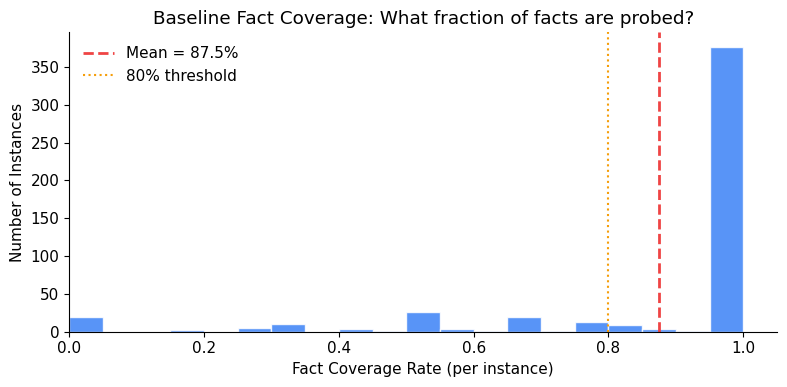

Saved: plot_coverage_histogram.png


In [60]:
# PLOT: Baseline Fact Coverage Distribution
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(coverage_rates, bins=20, color="#3b82f6", edgecolor="white", alpha=0.85)
ax.axvline(np.mean(coverage_rates), color="#ef4444", linestyle="--", linewidth=2,
           label=f"Mean = {np.mean(coverage_rates):.1%}")
ax.axvline(0.8, color="#f59e0b", linestyle=":", linewidth=1.5, label="80% threshold")
ax.set_xlabel("Fact Coverage Rate (per instance)")
ax.set_ylabel("Number of Instances")
ax.set_title("Baseline Fact Coverage: What fraction of facts are probed?")
ax.legend(frameon=False)
ax.set_xlim(0, 1.05)
plt.tight_layout()
os.makedirs(os.path.join(REPO_ROOT, "results", "contratico", "e3"), exist_ok=True)

plt.savefig(os.path.join(REPO_ROOT, "results", "contratico", "e3", "plot_coverage_histogram.png"), dpi=150)
plt.show()
print(f"Saved: plot_coverage_histogram.png")

In [61]:
# Show examples of uncovered facts (qualitative analysis)
print("=" * 60)
print("EXAMPLES OF UNCOVERED FACTS")
print("=" * 60)
for ex in uncovered_examples[:10]:
    print(f"\n[Instance {ex['idx']}] Coverage: {ex.get('n_covered', 0)}/{ex.get('n_facts', '?')}")
    print(f"  Source: {ex.get('source', 'N/A')}")
    for uf in ex.get("uncovered", []):
        print(f"  ✗ Uncovered: {uf}")

EXAMPLES OF UNCOVERED FACTS

[Instance 0] Coverage: 0/?
  Source: i will send you an image on your screen
  ✗ Uncovered: I will send you an image.
  ✗ Uncovered: The image will be sent on your screen.

[Instance 3] Coverage: 0/1
  Source: and drink lots of fluids
  ✗ Uncovered: Drink lots of fluids

[Instance 6] Coverage: 0/1
  Source: but if you have the cough
  ✗ Uncovered: You have the cough.

[Instance 15] Coverage: 0/?
  Source: i have made on the body around the chest area?
  ✗ Uncovered: I have made something on the body
  ✗ Uncovered: The location of what I have made is around the chest area

[Instance 16] Coverage: 1/2
  Source: it hurts in the chest
  ✗ Uncovered: It hurts

[Instance 20] Coverage: 5/6
  Source: Estimates of the parameters of the SEIR model are tractable on large data sets because of paralleliz
  ✗ Uncovered: The methods for estimating the parameters of the SEIR model have been implemented in several R libraries.

[Instance 23] Coverage: 0/1
  Source: This has

In [62]:
# Free SBERT model
del sbert_model
import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## 2. Question Generation — E3 (Per-Fact Coverage)

The repo's `atomic` variant passes all facts to the LLM in one call, generating N questions from M facts (N may be ≠ M). This extension enforces a 1-1 correspondence between 1 fact and 1 question in the prompt, calling the model once per instance.


In [63]:
# Cell [28]: Setup for E3 QG
import time
os.chdir(os.path.join(REPO_ROOT, "QG", "code"))

In [64]:
# Cell [29]: Load QG engine
from qg_qwen3_4b import QuestionGenerator

qg_engine = QuestionGenerator(model_id="Qwen/Qwen3-4B-Instruct-2507")

Loading QG model: Qwen/Qwen3-4B-Instruct-2507 on cuda...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Model loaded successfully.


In [ ]:
# Experiment 1
# E3: Generate ONE question per fact (per-fact coverage)
# The repo's "atomic" variant passes ALL facts at once. E3 loops over
# individual facts, calling the model once per fact with a singleton list.
# This approach was too computationally expensive and therefore replaced by the
# more efficient approach in Experiment 2 (next cell)

import time
import json
from pathlib import Path

INPUT_FILE = "QG/entailed_facts.jsonl"
FACTS_FILE = os.path.join(REPO_ROOT, "QG", "entailed_facts.jsonl")
OUTPUT_FILE = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-factcoverage.jsonl")

os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

# Load the atomic/NLI prompt template from the repo
from qg_prompt import prompts
atomic_template = prompts["atomic"]

# Load facts
facts_records = []
with open(FACTS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        facts_records.append(json.loads(line))

print(f"Loaded {len(facts_records)} instances from {FACTS_FILE}")

# Resume logic
processed_ids = set()
if os.path.exists(OUTPUT_FILE):
    with open(OUTPUT_FILE, "r", encoding="utf-8") as f:
        for line in f:
            try:
                rec = json.loads(line.strip())
                processed_ids.add(rec.get("id"))
            except:
                pass
    print(f"Resuming: {len(processed_ids)} already processed")

t0 = time.time()

with open(OUTPUT_FILE, "a", encoding="utf-8") as f_out:
    for rec in facts_records:
        rec_id = rec.get("id")
        if rec_id in processed_ids:
            continue

        sentence = rec.get("en", "")
        if not sentence:
            continue

        # Parse atomic_facts (may be JSON string or list)
        raw_facts = rec.get("atomic_facts", "[]")
        if isinstance(raw_facts, str):
            facts_list = json.loads(raw_facts)
        else:
            facts_list = raw_facts

        # Generate ONE question per fact
        all_questions = []
        for fact in facts_list:
            # Build prompt with singleton fact list
            singleton = json.dumps([fact])
            prompt = atomic_template.replace("{{sentence}}", sentence).replace("{{atomic_facts}}", singleton)

            # Call model
            response = qg_engine._call_model(prompt)

            # Parse response — expect a Python list string like '["question?"]'
            try:
                parsed = json.loads(response)
                if isinstance(parsed, list) and len(parsed) > 0:
                    all_questions.append(parsed[0])  # Take first question only
                else:
                    all_questions.append(response.strip())
            except (json.JSONDecodeError, TypeError):
                # Clean up raw response
                cleaned = response.strip().strip("[]'\"")
                all_questions.append(cleaned)

        print(f"[{rec_id}] {len(facts_list)} facts → {len(all_questions)} questions")

        # Save with same format as repo output
        out_rec = dict(rec)
        out_rec["questions"] = json.dumps(all_questions)  # Store as JSON string like repo does
        f_out.write(json.dumps(out_rec, ensure_ascii=False) + "\n")
        f_out.flush()

e3_qg_time = time.time() - t0
print(f"\nE3 QG complete: {e3_qg_time:.1f}s")
print(f"Output: {OUTPUT_FILE}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Loaded 500 instances from /content/drive/MyDrive/CucumBERT_askqe/QG/entailed_facts.jsonl
[CMU_1:6] 1 facts → 1 questions
[CMU_1:12] 1 facts → 1 questions
[CMU_1:34] 0 facts → 0 questions
[CMU_1:42] 1 facts → 1 questions
[CMU_1:48] 1 facts → 1 questions
[CMU_1:52] 0 facts → 0 questions
[CMU_1:59] 1 facts → 1 questions
[CMU_1:62] 5 facts → 5 questions
[CMU_1:67] 1 facts → 1 questions
[CMU_1:68] 2 facts → 2 questions
[CMU_1:75] 4 facts → 4 questions
[CMU_1:78] 2 facts → 2 questions
[CMU_1:88] 2 facts → 2 questions
[CMU_1:94] 1 facts → 1 questions
[CMU_1:101] 2 facts → 2 questions
[CMU_1:104] 1 facts → 1 questions
[CMU_1:105] 2 facts → 2 questions
[CMU_1:125] 2 facts → 2 questions
[PubMed_9:792] 1 facts → 1 questions
[PubMed_9:794] 4 facts → 4 questions
[PubMed_9:795] 4 facts → 4 questions
[PubMed_9:797] 4 facts → 4 questions
[PubMed_9:799] 3 facts → 3 questions
[PubMed_9:802] 2 facts → 2 questions
[PubMed_9:803] 3 facts → 3 questions
[PubMed_9:804] 10 facts → 10 questions
[PubMed_9:805] 5

KeyboardInterrupt: 

In [ ]:
# RUN ONLY IF YOU WANT TO FORCE-RUN THE NEXT CELL!
!rm -f /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-factcoverage.jsonl

In [65]:
# Experiment 2
# Cell [33]: E3 per-fact question generation
# E3: Generate ONE question per fact (per-fact coverage)
# Strategy: Single model call with 'factcoverage' prompt that enforces 1:1 mapping.
# Fallback: If count mismatch, retry with per-fact calls (M calls for M facts).

import time
import json
from pathlib import Path

INPUT_FILE = "QG/entailed_facts.jsonl"
FACTS_FILE = os.path.join(REPO_ROOT, "QG", "entailed_facts.jsonl")
OUTPUT_FILE = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-factcoverage.jsonl")
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

# Load the factcoverage prompt template
from qg_prompt import prompts
fc_template = prompts["factcoverage"]
atomic_template = prompts["atomic"]  # fallback

# Load facts
facts_records = []
with open(FACTS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        facts_records.append(json.loads(line))
print(f"Loaded {len(facts_records)} instances from {FACTS_FILE}")

# Resume logic
processed_ids = set()
if os.path.exists(OUTPUT_FILE):
    with open(OUTPUT_FILE, "r", encoding="utf-8") as f:
        for line in f:
            try:
                rec = json.loads(line.strip())
                processed_ids.add(rec.get("id"))
            except:
                pass
    print(f"Resuming: {len(processed_ids)} already processed")

t0 = time.time()
n_single_call, n_fallback = 0, 0

with open(OUTPUT_FILE, "a", encoding="utf-8") as f_out:
    for rec in facts_records:
        rec_id = rec.get("id")
        if rec_id in processed_ids:
            continue

        sentence = rec.get("en", "")
        if not sentence:
            continue

        # Parse atomic_facts (may be JSON string or list)
        raw_facts = rec.get("atomic_facts", "[]")
        if isinstance(raw_facts, str):
            facts_list = json.loads(raw_facts)
        else:
            facts_list = raw_facts

        n_facts = len(facts_list)

        # --- Attempt 1: Single call with factcoverage prompt ---
        prompt = fc_template.replace("{{sentence}}", sentence).replace("{{atomic_facts}}", str(facts_list))
        response = qg_engine._call_model(prompt)

        all_questions = []
        try:
            parsed = json.loads(response)
            if isinstance(parsed, list):
                all_questions = parsed
        except (json.JSONDecodeError, TypeError):
            pass

        # --- Check 1:1 mapping ---
        if len(all_questions) == n_facts:
            n_single_call += 1
            tag = "✓"
        else:
            # --- Fallback: per-fact calls ---
            n_fallback += 1
            tag = f"⟳ fallback ({len(all_questions)}→{n_facts})"
            all_questions = []
            for fact in facts_list:
                singleton = json.dumps([fact])
                prompt = atomic_template.replace("{{sentence}}", sentence).replace("{{atomic_facts}}", singleton)
                response = qg_engine._call_model(prompt)
                try:
                    parsed = json.loads(response)
                    if isinstance(parsed, list) and len(parsed) > 0:
                        all_questions.append(parsed[0])
                    else:
                        all_questions.append(response.strip())
                except (json.JSONDecodeError, TypeError):
                    cleaned = response.strip().strip("[]'\"")
                    all_questions.append(cleaned)

        print(f"[{rec_id}] {n_facts} facts → {len(all_questions)} questions {tag}")

        # Save with same format as repo output
        out_rec = dict(rec)
        out_rec["questions"] = json.dumps(all_questions)
        f_out.write(json.dumps(out_rec, ensure_ascii=False) + "\n")
        f_out.flush()


e3_qg_time = time.time() - t0
print(f"\nE3 QG complete: {e3_qg_time:.1f}s")
total_processed = n_single_call + n_fallback
if total_processed > 0:
    print(f"Single-call success: {n_single_call}/{total_processed} ({n_single_call/total_processed*100:.0f}%)")
    print(f"Fallback (per-fact): {n_fallback}/{total_processed}")
else:
    print(f"All instances already processed (resumed from previous run)")
print(f"Output: {OUTPUT_FILE}")

Loaded 500 instances from /content/drive/MyDrive/CucumBERT_askqe/QG/entailed_facts.jsonl
Resuming: 500 already processed

E3 QG complete: 0.0s
All instances already processed (resumed from previous run)
Output: /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-factcoverage.jsonl


In [66]:
# Cell [34]: Verify E3 question counts
# Verify E3 question counts match fact counts — join by ID
e3_questions_file = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-factcoverage.jsonl")
facts_file = os.path.join(REPO_ROOT, "QG", "entailed_facts.jsonl")

# Load by ID
e3_q_by_id = {}
with open(e3_questions_file) as f:
    for line in f:
        rec = json.loads(line)
        raw_q = rec.get("questions", "[]")
        qs = json.loads(raw_q) if isinstance(raw_q, str) else raw_q
        e3_q_by_id[rec["id"]] = qs

facts_by_id_check = {}
with open(facts_file) as f:
    for line in f:
        rec = json.loads(line)
        raw_f = rec.get("atomic_facts", "[]")
        fs = json.loads(raw_f) if isinstance(raw_f, str) else raw_f
        facts_by_id_check[rec["id"]] = fs

# Compare on shared IDs
shared = set(e3_q_by_id.keys()) & set(facts_by_id_check.keys())
n_match, n_mismatch, total_e3_q = 0, 0, 0
for sid in shared:
    n_q = len(e3_q_by_id[sid])
    n_f = len(facts_by_id_check[sid])
    total_e3_q += n_q
    if n_q == n_f:
        n_match += 1
    else:
        n_mismatch += 1

# Baseline question count
base_q_file = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-atomic.jsonl")
total_base_q = 0
with open(base_q_file) as f:
    for line in f:
        rec = json.loads(line)
        raw_q = rec.get("questions", "[]")
        qs = json.loads(raw_q) if isinstance(raw_q, str) else raw_q
        total_base_q += len(qs)

print(f"E3 instances: {len(e3_q_by_id)}")
print(f"Shared with facts: {len(shared)}")
print(f"E3 Q=F match: {n_match}/{n_match + n_mismatch}")
print(f"E3 total questions: {total_e3_q}")
print(f"Baseline total questions: {total_base_q}")
print(f"E3/Baseline ratio: {total_e3_q/max(total_base_q,1):.2f}x")

E3 instances: 500
Shared with facts: 500
E3 Q=F match: 500/500
E3 total questions: 1471
Baseline total questions: 1540
E3/Baseline ratio: 0.96x


In [67]:
# Cell [34b]: Verify E3 fact coverage
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json, numpy as np

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

COVERAGE_THRESHOLD = 0.7

facts_file = os.path.join(REPO_ROOT, "QG", "entailed_facts.jsonl")
e3_file = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-factcoverage.jsonl")

# Load by ID
facts_by_id = {}
with open(facts_file) as f:
    for line in f:
        rec = json.loads(line)
        raw = rec.get("atomic_facts", "[]")
        facts_by_id[rec["id"]] = json.loads(raw) if isinstance(raw, str) else raw

questions_by_id = {}
with open(e3_file) as f:
    for line in f:
        rec = json.loads(line)
        raw = rec.get("questions", "[]")
        questions_by_id[rec["id"]] = json.loads(raw) if isinstance(raw, str) else raw

shared_ids = sorted(set(facts_by_id) & set(questions_by_id))

coverage_results = []
for sid in shared_ids:
    facts = facts_by_id[sid]
    questions = questions_by_id[sid]
    if not facts:
        continue

    f_embs = sbert_model.encode(facts)
    q_embs = sbert_model.encode(questions) if questions else np.zeros((0, f_embs.shape[1]))

    if len(q_embs) == 0:
        coverage_results.append((sid, 0.0))
        continue

    sim = cosine_similarity(f_embs, q_embs)
    covered = sum(1 for row in sim if row.max() >= COVERAGE_THRESHOLD)
    coverage_results.append((sid, covered / len(facts)))

coverage_rates = [c for _, c in coverage_results]

print("=" * 60)
print("E3 FACT COVERAGE (should be ~100%)")
print("=" * 60)
print(f"Threshold: cosine similarity >= {COVERAGE_THRESHOLD}")
print(f"Instances analyzed: {len(coverage_rates)}")
print(f"Mean coverage: {np.mean(coverage_rates)*100:.1f}%")
print(f"Median coverage: {np.median(coverage_rates)*100:.1f}%")
print(f"Instances with 100% coverage: {sum(1 for c in coverage_rates if c >= 1.0)}/{len(coverage_rates)}")
print(f"Instances with <100% coverage: {sum(1 for c in coverage_rates if c < 1.0)}/{len(coverage_rates)}")

failures = [(sid, cov) for sid, cov in coverage_results if cov < 1.0]
if failures:
    print(f"\nInstances below 100% ({len(failures)}):")
    for sid, cov in failures[:10]:
        print(f"  {sid}: {cov*100:.0f}% — facts={facts_by_id[sid][:2]}... questions={questions_by_id[sid][:2]}...")
else:
    print("\n All instances have 100% fact coverage!")

del sbert_model
import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

E3 FACT COVERAGE (should be ~100%)
Threshold: cosine similarity >= 0.7
Instances analyzed: 497
Mean coverage: 95.8%
Median coverage: 100.0%
Instances with 100% coverage: 454/497
Instances with <100% coverage: 43/497

Instances below 100% (43):
  CMU_1:78: 50% — facts=['I have made something on the body', 'The location of what I have made is around the chest area']... questions=['What have I made on the body?', 'Where on the body have I made something?']...
  CMU_1:88: 0% — facts=['It hurts', 'The pain is located in the chest']... questions=['Does it hurt?', 'Where is the pain located?']...
  CMU_1:94: 0% — facts=['It is occurring right in the middle of my chest']... questions=['Where is the occurrence taking place in the body?']...
  PubMed_10:1003: 83% — facts=['Estimates of the parameters of the SEIR model are tractable on large data sets because of parallelizability.', 'The methods for estimating the parameters of the SEIR model have been implemented in several R libraries.']... que

In [68]:
# Free GPU memory
import shutil
del qg_engine
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
cache_dir = os.path.join(REPO_ROOT, "QG", "code", "models--Qwen--Qwen3-4B-Instruct-2507")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("QG model cache deleted.")

QG model cache deleted.


In [76]:
import json, os

# Check which IDs E3 generated questions for
e3_ids = set()
with open(os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-factcoverage.jsonl")) as f:
    for line in f:
        e3_ids.add(json.loads(line).get("id"))

print(f"E3 questions: {len(e3_ids)} instances\n")

# Check which IDs exist in BT files for each language pair
LANGUAGES = ["es", "fr"]

for lang in LANGUAGES:
    bt_dir = os.path.join(REPO_ROOT, "backtranslation", f"en-{lang}")
    print(f"--- en-{lang} ---")
    if not os.path.exists(bt_dir):
        print(f"  Directory not found: {bt_dir}\n")
        continue
    for pert in PERTURBATIONS:
        bt_file = os.path.join(bt_dir, f"bt-{pert}.jsonl")
        if os.path.exists(bt_file):
            bt_ids = set()
            with open(bt_file) as f:
                for line in f:
                    bt_ids.add(json.loads(line).get("id"))
            overlap = len(e3_ids & bt_ids)
            print(f"  {pert}: {len(bt_ids)} BT instances, {overlap}/{len(e3_ids)} overlap with E3")
        else:
            print(f"  {pert}: FILE NOT FOUND")
    print()

E3 questions: 500 instances

--- en-es ---
  synonym: 500 BT instances, 500/500 overlap with E3
  expansion_noimpact: 500 BT instances, 500/500 overlap with E3
  omission: 500 BT instances, 500/500 overlap with E3
  alteration: 500 BT instances, 500/500 overlap with E3

--- en-fr ---
  synonym: 500 BT instances, 500/500 overlap with E3
  expansion_noimpact: 500 BT instances, 500/500 overlap with E3
  omission: 500 BT instances, 500/500 overlap with E3
  alteration: 500 BT instances, 500/500 overlap with E3



## 3. QA on Source + QA on Backtranslation

In [71]:
# Cell [38]: Load QA engine
os.chdir(os.path.join(REPO_ROOT, "QA", "code"))

from qa_qwen3_4b import QuestionAnswerer
qa_engine = QuestionAnswerer(model_id="Qwen/Qwen3-4B-Instruct-2507")

Loading QA model: Qwen/Qwen3-4B-Instruct-2507 on cuda...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded successfully.


In [72]:
# Cell [39]: QA on source with E3 questions
# QA on source (English) using E3 questions
# We use pipeline_type="factcoverage"
qa_engine.answer_questions(
    input_file="QG/qwen3-4b/questions-factcoverage.jsonl",
    pipeline_type="factcoverage",
    sentence_key="en")

Starting QA Process.
Input: /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-factcoverage.jsonl
Output: /content/drive/MyDrive/CucumBERT_askqe/QA/qwen3-4b/en-factcoverage.jsonl
Found existing output file. Resuming...


In [77]:
# Cell [40]: Add E3 questions to BT files for all languages
os.chdir(os.path.join(REPO_ROOT, "backtranslation"))

QG_FILE = "QG/qwen3-4b/questions-factcoverage.jsonl"
LANGUAGES = ["es", "fr"]

for lang in LANGUAGES:
    print(f"\n--- en-{lang} ---")
    for pert in PERTURBATIONS:
        bt_file = f"backtranslation/en-{lang}/bt-{pert}.jsonl"
        output_file = f"backtranslation/en-{lang}/bt-{pert}-factcoverage.jsonl"
        print(f"Adding E3 questions to: en-{lang}/{pert}")
        !python add_questions.py --qg_file "{QG_FILE}" --target_file "{bt_file}" --output_file "{output_file}"


--- en-es ---
Adding E3 questions to: en-es/synonym
QG file: /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-factcoverage.jsonl
Target file: /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es/bt-synonym.jsonl
Output file: /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es/bt-synonym-factcoverage.jsonl
----------------------------------------
Loading questions from: /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-factcoverage.jsonl...
Loaded 500 questions into memory.
Processing: /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es/bt-synonym.jsonl -> /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es/bt-synonym-factcoverage.jsonl
Success! Updated 500 records with questions.
----------------------------------------
Adding E3 questions to: en-es/expansion_noimpact
QG file: /content/drive/MyDrive/CucumBERT_askqe/QG/qwen3-4b/questions-factcoverage.jsonl
Target file: /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es

In [78]:
# Cell [41]: QA on all BT files with E3 questions for all languages
os.chdir(os.path.join(REPO_ROOT, "QA", "code"))

LANGUAGES = ["es", "fr"]
LANG_KEYS = {"es": "bt_pert_es", "fr": "bt_pert_fr"}

for lang in LANGUAGES:
    print(f"\n--- en-{lang} ---")
    for pert in PERTURBATIONS:
        input_bt = f"backtranslation/en-{lang}/bt-{pert}-factcoverage.jsonl"
        print(f"\nQA on BT (E3): en-{lang}/{pert}")
        qa_engine.answer_questions(
            input_file=input_bt,
            pipeline_type="factcoverage",
            sentence_key=LANG_KEYS[lang])


--- en-es ---

QA on BT (E3): en-es/synonym
Starting QA Process.
Input: /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es/bt-synonym-factcoverage.jsonl
Output: /content/drive/MyDrive/CucumBERT_askqe/QA/qwen3-4b/es-factcoverage-synonym.jsonl
Found existing output file. Resuming...

QA on BT (E3): en-es/expansion_noimpact
Starting QA Process.
Input: /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es/bt-expansion_noimpact-factcoverage.jsonl
Output: /content/drive/MyDrive/CucumBERT_askqe/QA/qwen3-4b/es-factcoverage-expansion_noimpact.jsonl
Found existing output file. Resuming...

QA on BT (E3): en-es/omission
Starting QA Process.
Input: /content/drive/MyDrive/CucumBERT_askqe/backtranslation/en-es/bt-omission-factcoverage.jsonl
Output: /content/drive/MyDrive/CucumBERT_askqe/QA/qwen3-4b/es-factcoverage-omission.jsonl
Found existing output file. Resuming...

QA on BT (E3): en-es/alteration
Starting QA Process.
Input: /content/drive/MyDrive/CucumBERT_askqe/backtranslation

In [ ]:
# Cell [42]: Free QA engine
del qa_engine
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## 4. Evaluation — String Comparison & SBERT

In [121]:
# Cell [44]: String comparison evaluation using repo script
os.chdir(os.path.join(REPO_ROOT, "evaluation", "string-comparison"))
!python string_comparison.py --model "qwen3-4b"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Processing: es | vanilla | alteration
Saved results to: /content/drive/MyDrive/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/alteration.jsonl
--------------------------------------------------------------------------------
Processing: es | vanilla | expansion_noimpact
Saved results to: /content/drive/MyDrive/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/expansion_noimpact.jsonl
--------------------------------------------------------------------------------
Processing: es | vanilla | omission
Saved results to: /content/drive/MyDrive/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/omission.jsonl
--------------------------------------------------------------------------------
Processing: es | vanilla | synonym
Saved results to: /content/drive/MyDrive/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/synonym.jsonl
--------------------

In [123]:
# Cell [45]: SBERT evaluation
os.chdir(os.path.join(REPO_ROOT, "evaluation", "sbert"))
!python sbert.py --model "qwen3-4b" --output_file "evaluation/sbert/qwen3-4b-e3.csv"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2026-02-14 20:31:30.268666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771101090.290960   72163 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771101090.298361   72163 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771101090.317364   72163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771101090.317391   72163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same

---
## 5. E3-Specific Analysis
 We compare E3 vs baseline across all 4 perturbation types, compute correlation, and measure E3-specific metrics.

### 5a. Load E3 Scores

In [126]:
# Cell [49]: Load E3 and baseline string comparison scores — both languages
import json
import numpy as np

LANGUAGES = ["es", "fr"]

def load_pert_scores(lang, variant, perturbations):
    """Load scores from evaluation output files for a given language."""
    lang_scores_dir = os.path.join(REPO_ROOT, "evaluation", "string-comparison", f"en-{lang}")
    results = {}
    for pert in perturbations:
        filepath = os.path.join(lang_scores_dir, variant, f"{pert}.jsonl")
        if not os.path.exists(filepath):
            print(f"  Warning: {filepath} not found")
            continue
        f1s, ems = [], []
        with open(filepath) as f:
            for line in f:
                rec = json.loads(line)
                if "avg_f1" in rec:
                    f1s.append(rec["avg_f1"])
                    ems.append(rec.get("avg_em", 0))
                elif "scores" in rec:
                    rec_f1s = [s.get("f1", 0) for s in rec["scores"]]
                    rec_ems = [s.get("em", 0) for s in rec["scores"]]
                    if rec_f1s:
                        f1s.append(np.mean(rec_f1s))
                        ems.append(np.mean(rec_ems))
        if f1s:
            results[pert] = {
                "f1": np.mean(f1s), "em": np.mean(ems),
                "n": len(f1s),
                "f1_per_instance": f1s,
            }
    return results

# Load scores for all languages
all_e3_scores = {}
all_baseline_scores = {}

for lang in LANGUAGES:
    print(f"\n{'='*60}")
    print(f"EN-{lang.upper()}")
    print(f"{'='*60}")

    all_e3_scores[lang] = load_pert_scores(lang, "factcoverage", PERTURBATIONS)
    print(f"E3 scores: {len(all_e3_scores[lang])}/{len(PERTURBATIONS)} perturbations")
    for p, s in all_e3_scores[lang].items():
        print(f"  {p}: F1={s['f1']:.4f}, EM={s['em']:.4f}, n={s['n']}")

    all_baseline_scores[lang] = load_pert_scores(lang, "atomic", PERTURBATIONS)
    print(f"\nBaseline scores: {len(all_baseline_scores[lang])}/{len(PERTURBATIONS)} perturbations")
    for p, s in all_baseline_scores[lang].items():
        print(f"  {p}: F1={s['f1']:.4f}, EM={s['em']:.4f}, n={s['n']}")



EN-ES
E3 scores: 4/4 perturbations
  synonym: F1=0.8423, EM=0.7319, n=482
  expansion_noimpact: F1=0.8623, EM=0.7394, n=484
  omission: F1=0.7148, EM=0.6103, n=480
  alteration: F1=0.4436, EM=0.3378, n=475

Baseline scores: 4/4 perturbations
  synonym: F1=0.7669, EM=0.5498, n=484
  expansion_noimpact: F1=0.7899, EM=0.5555, n=484
  omission: F1=0.6733, EM=0.4538, n=482
  alteration: F1=0.4442, EM=0.2403, n=474

EN-FR
E3 scores: 4/4 perturbations
  synonym: F1=0.8557, EM=0.7402, n=481
  expansion_noimpact: F1=0.8717, EM=0.7486, n=486
  omission: F1=0.6949, EM=0.5965, n=481
  alteration: F1=0.4127, EM=0.3097, n=472

Baseline scores: 4/4 perturbations
  synonym: F1=0.7810, EM=0.5561, n=486
  expansion_noimpact: F1=0.7901, EM=0.5554, n=485
  omission: F1=0.6568, EM=0.4530, n=482
  alteration: F1=0.4379, EM=0.2437, n=473


In [113]:
# Cell [50]: Baseline vs E3 table — both languages
for lang in LANGUAGES:
    e3_lang = all_e3_scores.get(lang, {})
    base_lang = all_baseline_scores.get(lang, {})

    print(f"\n{'='*110}")
    print(f"EN-{lang.upper()}: BASELINE vs E3 ASKQE Scores by Perturbation Type")
    print(f"{'='*110}")
    print(f"{'Severity':<10} {'Perturbation':<22} | {'Base F1':>8} {'E3 F1':>8} {'Δ F1':>8} | {'Base EM':>8} {'E3 EM':>8} {'Δ EM':>8}")
    print("-" * 110)

    minor_base_f1, minor_e3_f1, crit_base_f1, crit_e3_f1 = [], [], [], []

    for sev, plist in [("Minor", MINOR), ("Critical", CRITICAL)]:
        for p in plist:
            b = base_lang.get(p, {})
            e = e3_lang.get(p, {})
            bf1 = b.get("f1", float("nan"))
            ef1 = e.get("f1", float("nan"))
            bem = b.get("em", float("nan"))
            eem = e.get("em", float("nan"))
            df1 = ef1 - bf1 if not (np.isnan(ef1) or np.isnan(bf1)) else float("nan")
            dem = eem - bem if not (np.isnan(eem) or np.isnan(bem)) else float("nan")

            print(f"{sev:<10} {p:<22} | {bf1:>8.4f} {ef1:>8.4f} {df1:>+8.4f} | {bem:>8.4f} {eem:>8.4f} {dem:>+8.4f}")

            if not np.isnan(bf1):
                (minor_base_f1 if sev == "Minor" else crit_base_f1).append(bf1)
            if not np.isnan(ef1):
                (minor_e3_f1 if sev == "Minor" else crit_e3_f1).append(ef1)
        print()

    print("-" * 110)
    if minor_base_f1 and crit_base_f1 and minor_e3_f1 and crit_e3_f1:
        base_gap = np.mean(minor_base_f1) - np.mean(crit_base_f1)
        e3_gap = np.mean(minor_e3_f1) - np.mean(crit_e3_f1)
        print(f"Minor-Critical gap: Baseline={base_gap:.4f}, E3={e3_gap:.4f}")
        print(f"Overall Δ F1 (E3-Base): Minor={np.mean(minor_e3_f1)-np.mean(minor_base_f1):+.4f}, "
              f"Critical={np.mean(crit_e3_f1)-np.mean(crit_base_f1):+.4f}")


EN-ES: BASELINE vs E3 ASKQE Scores by Perturbation Type
Severity   Perturbation           |  Base F1    E3 F1     Δ F1 |  Base EM    E3 EM     Δ EM
--------------------------------------------------------------------------------------------------------------
Minor      synonym                |   0.7669   0.8423  +0.0754 |   0.5498   0.7319  +0.1821
Minor      expansion_noimpact     |   0.7899   0.8623  +0.0724 |   0.5555   0.7394  +0.1839

Critical   omission               |   0.6733   0.7148  +0.0415 |   0.4538   0.6103  +0.1565
Critical   alteration             |   0.4442   0.4436  -0.0006 |   0.2403   0.3378  +0.0975

--------------------------------------------------------------------------------------------------------------
Minor-Critical gap: Baseline=0.2197, E3=0.2731
Overall Δ F1 (E3-Base): Minor=+0.0739, Critical=+0.0204

EN-FR: BASELINE vs E3 ASKQE Scores by Perturbation Type
Severity   Perturbation           |  Base F1    E3 F1     Δ F1 |  Base EM    E3 EM     Δ EM
-------

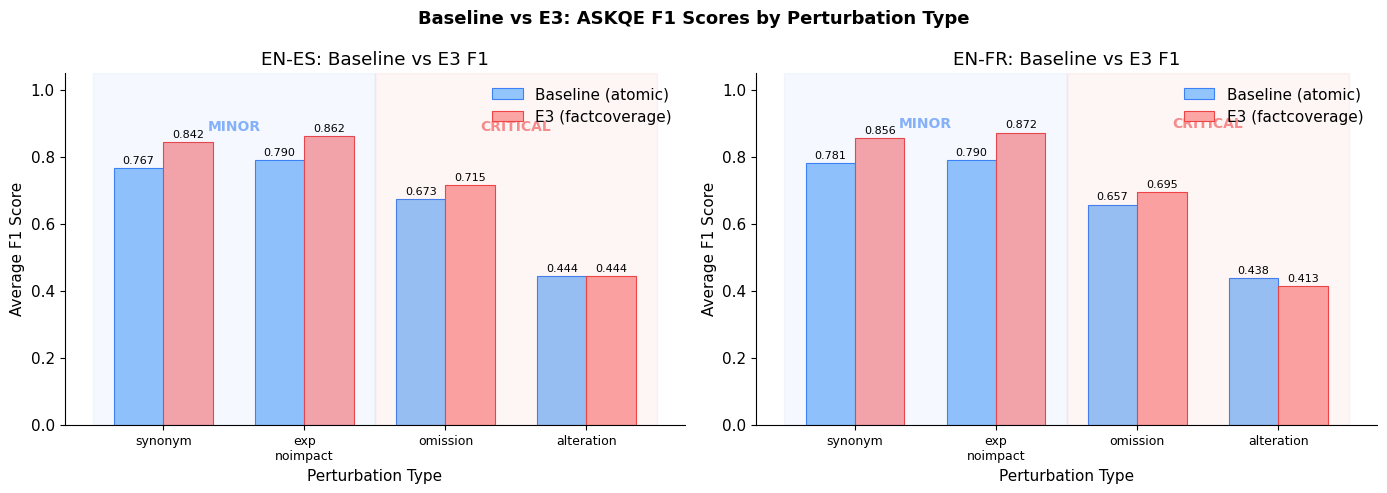

Saved: plot_baseline_vs_e3_f1.png


In [114]:
# Cell [53]: Plot baseline vs E3 bars — both languages
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(7 * len(LANGUAGES), 5))
if len(LANGUAGES) == 1:
    axes = [axes]

for ax, lang in zip(axes, LANGUAGES):
    e3_lang = all_e3_scores.get(lang, {})
    base_lang = all_baseline_scores.get(lang, {})

    plot_perts = []
    base_f1_vals = []
    e3_f1_vals = []

    for sev, plist in [("Minor", MINOR), ("Critical", CRITICAL)]:
        for p in plist:
            b = base_lang.get(p, {})
            e = e3_lang.get(p, {})
            bf1 = b.get("f1", None)
            ef1 = e.get("f1", None)
            if bf1 is not None and ef1 is not None:
                plot_perts.append(p.replace("expansion_", "exp_").replace("_", "\n"))
                base_f1_vals.append(bf1)
                e3_f1_vals.append(ef1)

    if not plot_perts:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"EN-{lang.upper()}")
        continue

    x = np.arange(len(plot_perts))
    width = 0.35

    bars1 = ax.bar(x - width/2, base_f1_vals, width, label="Baseline (atomic)",
                   color="#93c5fd", edgecolor="#3b82f6", linewidth=0.8)
    bars2 = ax.bar(x + width/2, e3_f1_vals, width, label="E3 (factcoverage)",
                   color="#fca5a5", edgecolor="#ef4444", linewidth=0.8)

    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.008,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.008,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

    n_minor = len(MINOR)
    ax.axvspan(-0.5, n_minor - 0.5, alpha=0.05, color="#3b82f6")
    ax.axvspan(n_minor - 0.5, len(plot_perts) - 0.5, alpha=0.05, color="#ef4444")
    ax.text(n_minor/2 - 0.5, ax.get_ylim()[1] * 0.97, "MINOR", ha="center",
            fontsize=10, color="#3b82f6", fontweight="bold", alpha=0.6)
    ax.text(n_minor + (len(plot_perts) - n_minor)/2 - 0.5, ax.get_ylim()[1] * 0.97, "CRITICAL",
            ha="center", fontsize=10, color="#ef4444", fontweight="bold", alpha=0.6)

    ax.set_xlabel("Perturbation Type")
    ax.set_ylabel("Average F1 Score")
    ax.set_title(f"EN-{lang.upper()}: Baseline vs E3 F1")
    ax.set_xticks(x)
    ax.set_xticklabels(plot_perts, fontsize=9)
    ax.legend(frameon=False, loc="upper right")
    ax.set_ylim(0, 1.05)

plt.suptitle("Baseline vs E3: ASKQE F1 Scores by Perturbation Type", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(REPO_ROOT, "results", "contratico", "e3", "plot_baseline_vs_e3_f1.png"), dpi=150)
plt.show()
print("Saved: plot_baseline_vs_e3_f1.png")

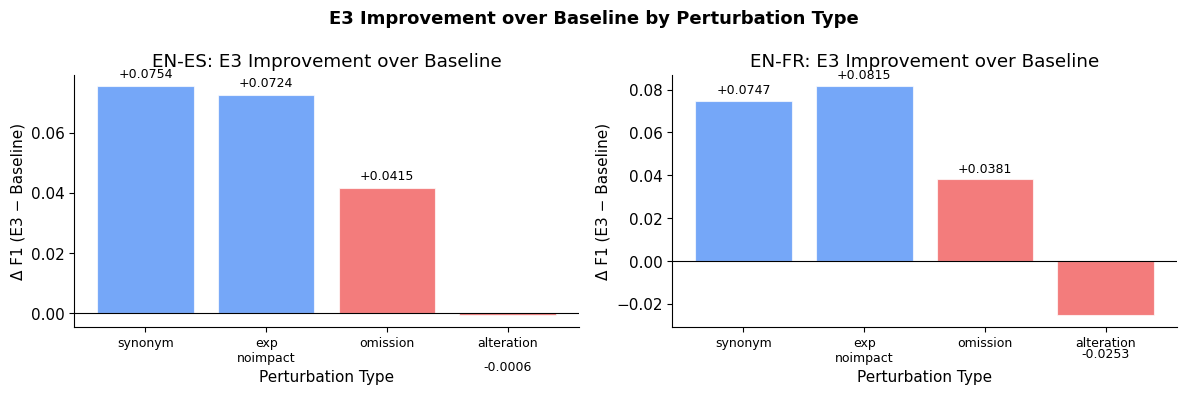

Saved: plot_delta_f1.png


In [115]:
# Cell [54]: Plot delta F1 — both languages
fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(6 * len(LANGUAGES), 4))
if len(LANGUAGES) == 1:
    axes = [axes]

for ax, lang in zip(axes, LANGUAGES):
    e3_lang = all_e3_scores.get(lang, {})
    base_lang = all_baseline_scores.get(lang, {})

    delta_perts = []
    delta_vals = []
    delta_colors = []

    for sev, plist, col in [("Minor", MINOR, "#3b82f6"), ("Critical", CRITICAL, "#ef4444")]:
        for p in plist:
            b = base_lang.get(p, {}).get("f1", None)
            e = e3_lang.get(p, {}).get("f1", None)
            if b is not None and e is not None:
                delta_perts.append(p.replace("expansion_", "exp_").replace("_", "\n"))
                delta_vals.append(e - b)
                delta_colors.append(col)

    if not delta_perts:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"EN-{lang.upper()}")
        continue

    x = np.arange(len(delta_perts))
    bars = ax.bar(x, delta_vals, color=delta_colors, alpha=0.7, edgecolor="white", linewidth=0.8)

    for bar, val in zip(bars, delta_vals):
        y_pos = bar.get_height() + 0.002 if val >= 0 else bar.get_height() - 0.015
        ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{val:+.4f}', ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)

    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xlabel("Perturbation Type")
    ax.set_ylabel("Δ F1 (E3 − Baseline)")
    ax.set_title(f"EN-{lang.upper()}: E3 Improvement over Baseline")
    ax.set_xticks(x)
    ax.set_xticklabels(delta_perts, fontsize=9)

plt.suptitle("E3 Improvement over Baseline by Perturbation Type", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(REPO_ROOT, "results", "contratico", "e3", "plot_delta_f1.png"), dpi=150)
plt.show()
print("Saved: plot_delta_f1.png")

### 5c. Figure 4 Extended: Pearson Correlation (E3 vs QE Baselines)

In [127]:
# Cell [57]: Pearson correlation
os.chdir(os.path.join(REPO_ROOT, "evaluation", "pearson-correlation"))

LANGUAGES = ["en-es", "en-fr"]
PIPELINES_TO_COMPARE = ["atomic", "factcoverage"]

for dataset in LANGUAGES:
    print(f"\n{'='*60}")
    print(f"Computing correlations for {dataset}")
    print(f"{'='*60}")
    !python compute_correlation.py --dataset "{dataset}"


Computing correlations for en-es
Loading standard metric: xcomet
  2000 instances loaded
Loading standard metric: bt_score
  2000 instances loaded
Loading AskQE metric: f1-vanilla
  1972 instances loaded
Loading AskQE metric: f1-atomic
  1924 instances loaded
Loading AskQE metric: f1-factcoverage
  1921 instances loaded
Loading AskQE metric: em-vanilla
  1972 instances loaded
Loading AskQE metric: em-atomic
  1924 instances loaded
Loading AskQE metric: em-factcoverage
  1921 instances loaded
Loading AskQE metric: bleu-vanilla
  1972 instances loaded
Loading AskQE metric: bleu-atomic
  1924 instances loaded
Loading AskQE metric: bleu-factcoverage
  1921 instances loaded
Loading AskQE metric: chrf-vanilla
  1972 instances loaded
Loading AskQE metric: chrf-atomic
  1924 instances loaded
Loading AskQE metric: chrf-factcoverage
  1921 instances loaded
Loading AskQE metric: sbert-vanilla
  1972 instances loaded
Loading AskQE metric: sbert-atomic
  1924 instances loaded
Loading AskQE metric:

PEARSON CORRELATION SUMMARY: Instance-Level (AskQE vs QE Baselines)
Dataset                 AskQE Metric     Standard        r            p        n
----------------------------------------------------------------------------------------------------
en-es                      f1-atomic       xcomet   0.3915     1.76e-71     1924
en-es                      f1-atomic     bt_score   0.3370     2.63e-52     1924
en-es                      em-atomic       xcomet   0.2793     8.43e-36     1924
en-es                      em-atomic     bt_score   0.2132     3.29e-21     1924

en-es                f1-factcoverage       xcomet   0.4313     7.23e-88     1921
en-es                f1-factcoverage     bt_score   0.3630     6.74e-61     1921
en-es                em-factcoverage       xcomet   0.3479     9.13e-56     1921
en-es                em-factcoverage     bt_score   0.2691     3.27e-33     1921

en-fr                      f1-atomic       xcomet   0.3889     1.43e-70     1926
en-fr              

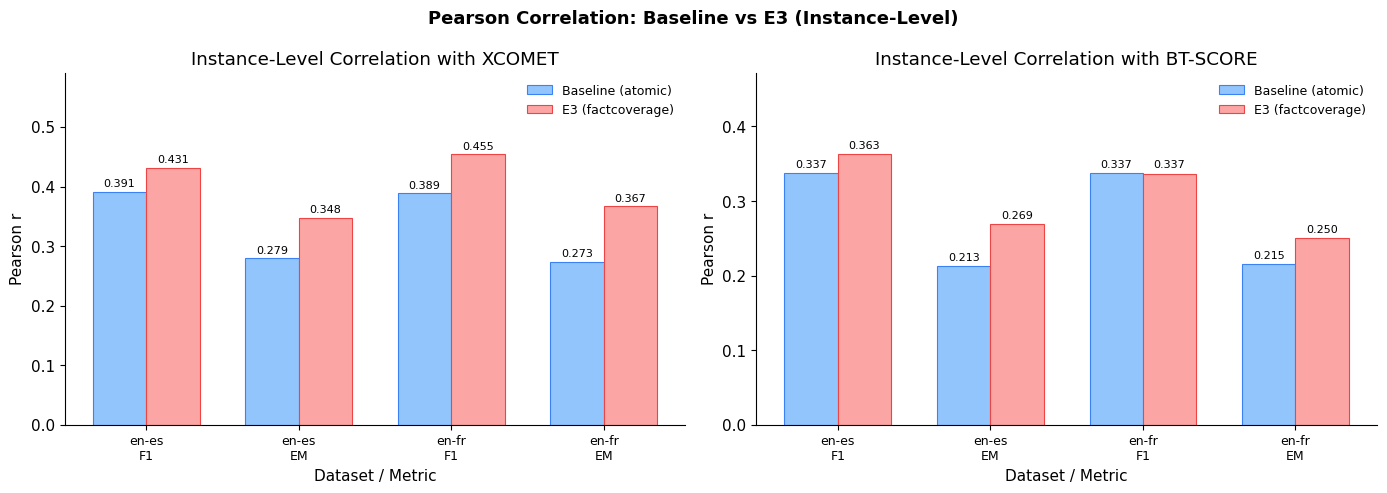

Saved: plot_pearson_comparison.png


In [129]:
# Cell [57b]: Collect and display Pearson correlation results
import json, os, re, numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

results_dir = os.path.join(REPO_ROOT, "evaluation", "pearson-correlation")
DATASETS = ["en-es", "en-fr"]

# Load results from JSON files
all_correlations = {}

for dataset in DATASETS:
    results_file = os.path.join(results_dir, f"results_{dataset}.json")
    if not os.path.exists(results_file):
        print(f"Warning: {results_file} not found")
        continue
    with open(results_file) as f:
        data = json.load(f)
    for c in data.get("correlations", []):
        # askqe_metric is like "f1-atomic", "f1-factcoverage"
        ak = c["askqe_metric"]
        sm = c["standard_metric"]
        key = (dataset, ak, sm)
        all_correlations[key] = {
            "r": c.get("pearson_r"),
            "p": c.get("p_value"),
            "n": c.get("n_instances", 0)
        }

# Print summary table
print("=" * 100)
print("PEARSON CORRELATION SUMMARY: Instance-Level (AskQE vs QE Baselines)")
print("=" * 100)
print(f"{'Dataset':<10} {'AskQE Metric':>25} {'Standard':>12} {'r':>8} {'p':>12} {'n':>8}")
print("-" * 100)

PIPELINES_SHOW = ["atomic", "factcoverage"]
ASKQE_SHOW = ["f1", "em"]
STANDARD_SHOW = ["xcomet", "bt_score"]

for dataset in DATASETS:
    for pipeline in PIPELINES_SHOW:
        for askqe in ASKQE_SHOW:
            for standard in STANDARD_SHOW:
                ak_label = f"{askqe}-{pipeline}"
                key = (dataset, ak_label, standard)
                if key in all_correlations:
                    res = all_correlations[key]
                    r_str = f"{res['r']:.4f}" if res['r'] is not None else "N/A"
                    p_str = f"{res['p']:.2e}" if res['p'] is not None else "N/A"
                    print(f"{dataset:<10} {ak_label:>25} {standard:>12} {r_str:>8} {p_str:>12} {res['n']:>8}")
        print()

# --- PLOT ---
fig, axes = plt.subplots(1, len(STANDARD_SHOW), figsize=(7 * len(STANDARD_SHOW), 5))
if len(STANDARD_SHOW) == 1:
    axes = [axes]

for ax, standard in zip(axes, STANDARD_SHOW):
    labels = []
    atomic_vals = []
    factcov_vals = []

    for dataset in DATASETS:
        for askqe in ASKQE_SHOW:
            label = f"{dataset}\n{askqe.upper()}"
            labels.append(label)

            r_atomic = all_correlations.get((dataset, f"{askqe}-atomic", standard), {}).get("r", 0) or 0
            r_factcov = all_correlations.get((dataset, f"{askqe}-factcoverage", standard), {}).get("r", 0) or 0
            atomic_vals.append(r_atomic)
            factcov_vals.append(r_factcov)

    x = np.arange(len(labels))
    width = 0.35

    bars1 = ax.bar(x - width/2, atomic_vals, width, label="Baseline (atomic)",
                   color="#93c5fd", edgecolor="#3b82f6", linewidth=0.8)
    bars2 = ax.bar(x + width/2, factcov_vals, width, label="E3 (factcoverage)",
                   color="#fca5a5", edgecolor="#ef4444", linewidth=0.8)

    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel("Dataset / Metric")
    ax.set_ylabel("Pearson r")
    ax.set_title(f"Instance-Level Correlation with {standard.replace('_', '-').upper()}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_ylim(0, max(max(atomic_vals + [0.01]), max(factcov_vals + [0.01])) * 1.3)
    ax.legend(frameon=False, fontsize=9)

plt.suptitle("Pearson Correlation: Baseline vs E3 (Instance-Level)", fontsize=13, fontweight="bold")
plt.tight_layout()
os.makedirs(os.path.join(REPO_ROOT, "results", "contratico", "e3"), exist_ok=True)
plt.savefig(os.path.join(REPO_ROOT, "results", "contratico", "e3", "plot_pearson_comparison.png"), dpi=150)
plt.show()
print("Saved: plot_pearson_comparison.png")

In [120]:
# Cell [58]: Silhouette score — severity discrimination, both languages
os.chdir(os.path.join(REPO_ROOT, "evaluation", "silhouette"))

LANGUAGES = ["en-es", "en-fr"]

for lang in LANGUAGES:
    print(f"\n{'='*60}")
    print(f"Silhouette scores: {lang}")
    print(f"{'='*60}")
    !python silhouette_score.py --target-lang "{lang}" --plot


Silhouette scores: en-es

Processing pipeline: vanilla
  Loaded 490 items from omission
  Loaded 492 items from alteration
  Loaded 495 items from synonym
  Loaded 495 items from expansion_noimpact
  SBERT        silhouette=0.064056  (n=1972)
    KDE plot saved to /content/drive/MyDrive/CucumBERT_askqe/evaluation/silhouette/plots/kde_sbert_vanilla_en-es.png
  F1           silhouette=0.045316  (n=1972)
    KDE plot saved to /content/drive/MyDrive/CucumBERT_askqe/evaluation/silhouette/plots/kde_f1_vanilla_en-es.png
  EM           silhouette=0.015480  (n=1972)
    KDE plot saved to /content/drive/MyDrive/CucumBERT_askqe/evaluation/silhouette/plots/kde_em_vanilla_en-es.png
  CHRF         silhouette=0.055698  (n=1972)
    KDE plot saved to /content/drive/MyDrive/CucumBERT_askqe/evaluation/silhouette/plots/kde_chrf_vanilla_en-es.png
  BLEU         silhouette=0.032549  (n=1972)
    KDE plot saved to /content/drive/MyDrive/CucumBERT_askqe/evaluation/silhouette/plots/kde_bleu_vanilla_en-es.png

In [110]:
# Cell [58b]: Silhouette results summary
import json, os

LANGUAGES = ["en-es", "en-fr"]
sil_dir = os.path.join(REPO_ROOT, "evaluation", "silhouette")

for lang in LANGUAGES:
    results_file = os.path.join(sil_dir, f"results_{lang}.json")
    if not os.path.exists(results_file):
        print(f"{lang}: no results file")
        continue

    with open(results_file) as f:
        data = json.load(f)

    print(f"\n{'='*70}")
    print(f"SILHOUETTE SCORES: {lang} (higher = better severity discrimination)")
    print(f"{'='*70}")
    print(f"{'Pipeline':<20} {'SBERT':>10} {'F1':>10} {'EM':>10} {'chrF':>10} {'BLEU':>10}")
    print("-" * 70)

    for result in data.get("results", []):
        pipeline = result["pipeline"]
        if result.get("anscheck_type"):
            pipeline += f"_{result['anscheck_type']}"
        metrics = result.get("metrics", {})
        vals = []
        for m in ["sbert", "f1", "em", "chrf", "bleu"]:
            s = metrics.get(m, {}).get("silhouette_score")
            vals.append(f"{s:>10.4f}" if s is not None else f"{'N/A':>10}")
        print(f"{pipeline:<20} {'  '.join(vals)}")

    # MT baselines
    mt = data.get("mt_results", {})
    mt_vals = []
    for m in ["xcomet", "bertscore"]:
        s = mt.get(m, {}).get("silhouette_score")
        mt_vals.append(f"{m}: {s:.4f}" if s is not None else f"{m}: N/A")
    print(f"\nMT baselines: {', '.join(mt_vals)}")


SILHOUETTE SCORES: en-es (higher = better severity discrimination)
Pipeline                  SBERT         F1         EM       chrF       BLEU
----------------------------------------------------------------------
vanilla                  0.0641      0.0453      0.0155      0.0557      0.0325
atomic                   0.1010      0.1161      0.0721      0.1273      0.0946
factcoverage             0.1399      0.1729      0.1298      0.1767      0.1506

MT baselines: xcomet: 0.2042, bertscore: 0.0963

SILHOUETTE SCORES: en-fr (higher = better severity discrimination)
Pipeline                  SBERT         F1         EM       chrF       BLEU
----------------------------------------------------------------------
vanilla                  0.0705      0.0558      0.0255      0.0564      0.0374
atomic                   0.1052      0.1307      0.0712      0.1347      0.0962
factcoverage             0.1688      0.2098      0.1560      0.2093      0.1800

MT baselines: xcomet: 0.2223, bertscore:

### 5d. E3-Specific: Min-F1 and Mismatch Fraction

In [99]:
# Cell [59]: Min-F1 and mismatch fraction — both languages, baseline vs E3
import json, os, numpy as np

LANGUAGES = ["es", "fr"]
PIPELINES_TO_SHOW = ["atomic", "factcoverage"]

scores_dir = os.path.join(REPO_ROOT, "evaluation", "string-comparison")

print("=" * 90)
print("MISMATCH FRACTION & MIN-F1: Baseline vs E3")
print("=" * 90)

for lang in LANGUAGES:
    print(f"\n--- EN-{lang.upper()} ---")
    print(f"{'Pipeline':<15} {'Perturbation':<22} {'mean_F1':>10} {'min_F1':>10} {'mismatch':>10} {'n':>6}")
    print("-" * 80)

    for pipeline in PIPELINES_TO_SHOW:
        for pert in PERTURBATIONS:
            filepath = os.path.join(scores_dir, f"en-{lang}", pipeline, f"{pert}.jsonl")
            if not os.path.exists(filepath):
                continue

            f1s = []
            with open(filepath) as f:
                for line in f:
                    rec = json.loads(line)
                    if "avg_f1" in rec:
                        f1s.append(rec["avg_f1"])
                    elif "scores" in rec:
                        s = [s.get("f1", 0) for s in rec["scores"]]
                        if s:
                            f1s.append(np.mean(s))

            if f1s:
                min_f1 = np.min(f1s)
                mismatch_frac = sum(1 for f in f1s if f < 1.0) / len(f1s)
                print(f"{pipeline:<15} {pert:<22} {np.mean(f1s):>10.4f} {min_f1:>10.4f} {mismatch_frac:>9.1%} {len(f1s):>6}")
        print()

print("\nInterpretation:")
print("  min_F1: worst-case detection (weakest link across questions)")
print("  mismatch_frac: % of instances where at least one answer differs")
print("  Higher mismatch_frac for critical = good error sensitivity")
print("  Compare atomic vs factcoverage to see if E3 improves separation")

MISMATCH FRACTION & MIN-F1: Baseline vs E3

--- EN-ES ---
Pipeline        Perturbation              mean_F1     min_F1   mismatch      n
--------------------------------------------------------------------------------
atomic          synonym                    0.7669     0.0000     66.7%    484
atomic          expansion_noimpact         0.7899     0.0000     66.3%    484
atomic          omission                   0.6733     0.0000     76.8%    482
atomic          alteration                 0.4442     0.0000     93.2%    474

factcoverage    synonym                    0.8423     0.0000     40.2%    482
factcoverage    expansion_noimpact         0.8623     0.0000     36.6%    484
factcoverage    omission                   0.7148     0.0000     63.1%    480
factcoverage    alteration                 0.4436     0.0000     87.2%    475


--- EN-FR ---
Pipeline        Perturbation              mean_F1     min_F1   mismatch      n
--------------------------------------------------------------

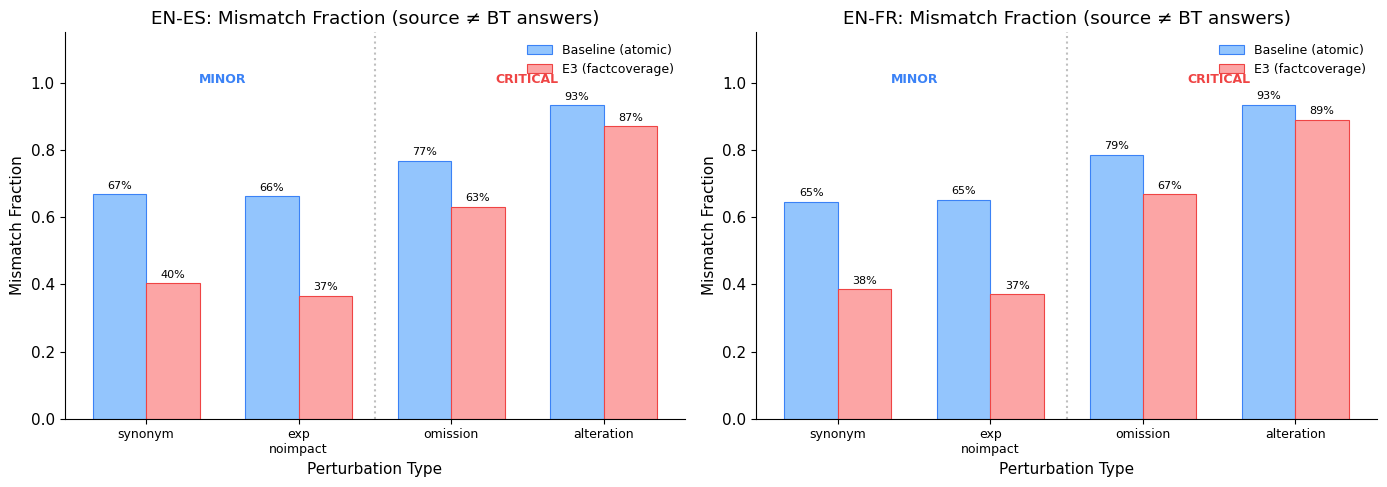

Saved: plot_mismatch_fraction.png


In [100]:
# Cell [60]: Plot mismatch fraction — baseline vs E3, both languages
import matplotlib.pyplot as plt
import matplotlib
import json, os, numpy as np

matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

scores_dir = os.path.join(REPO_ROOT, "evaluation", "string-comparison")
LANGUAGES = ["es", "fr"]

def load_mismatch(lang, pipeline):
    """Load mismatch fraction per perturbation."""
    results = {}
    for pert in PERTURBATIONS:
        filepath = os.path.join(scores_dir, f"en-{lang}", pipeline, f"{pert}.jsonl")
        if not os.path.exists(filepath):
            continue
        f1s = []
        with open(filepath) as f:
            for line in f:
                rec = json.loads(line)
                if "avg_f1" in rec:
                    f1s.append(rec["avg_f1"])
                elif "scores" in rec:
                    s = [s.get("f1", 0) for s in rec["scores"]]
                    if s:
                        f1s.append(np.mean(s))
        if f1s:
            results[pert] = sum(1 for f in f1s if f < 1.0) / len(f1s)
    return results

fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(7 * len(LANGUAGES), 5))
if len(LANGUAGES) == 1:
    axes = [axes]

for ax, lang in zip(axes, LANGUAGES):
    base_mm = load_mismatch(lang, "atomic")
    e3_mm = load_mismatch(lang, "factcoverage")

    perts_to_plot = []
    base_vals = []
    e3_vals = []

    for sev, plist in [("Minor", MINOR), ("Critical", CRITICAL)]:
        for p in plist:
            if p in base_mm and p in e3_mm:
                perts_to_plot.append(p.replace("expansion_", "exp_").replace("_", "\n"))
                base_vals.append(base_mm[p])
                e3_vals.append(e3_mm[p])

    if not perts_to_plot:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"EN-{lang.upper()}")
        continue

    x = np.arange(len(perts_to_plot))
    width = 0.35

    bars1 = ax.bar(x - width/2, base_vals, width, label="Baseline (atomic)",
                   color="#93c5fd", edgecolor="#3b82f6", linewidth=0.8)
    bars2 = ax.bar(x + width/2, e3_vals, width, label="E3 (factcoverage)",
                   color="#fca5a5", edgecolor="#ef4444", linewidth=0.8)

    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{bar.get_height():.0%}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{bar.get_height():.0%}', ha='center', va='bottom', fontsize=8)

    n_minor = len(MINOR)
    ax.axvline(n_minor - 0.5, color="gray", linestyle=":", alpha=0.5)
    ax.text(n_minor/2 - 0.5, 1.0, "MINOR", ha="center", fontsize=9, color="#3b82f6", fontweight="bold")
    ax.text(n_minor + (len(perts_to_plot) - n_minor)/2 - 0.5, 1.0, "CRITICAL", ha="center",
            fontsize=9, color="#ef4444", fontweight="bold")

    ax.set_xlabel("Perturbation Type")
    ax.set_ylabel("Mismatch Fraction")
    ax.set_title(f"EN-{lang.upper()}: Mismatch Fraction (source ≠ BT answers)")
    ax.set_xticks(x)
    ax.set_xticklabels(perts_to_plot, fontsize=9)
    ax.set_ylim(0, 1.15)
    ax.legend(frameon=False, fontsize=9)

plt.tight_layout()
os.makedirs(os.path.join(REPO_ROOT, "results", "contratico", "e3"), exist_ok=True)
plt.savefig(os.path.join(REPO_ROOT, "results", "contratico", "e3", "plot_mismatch_fraction.png"), dpi=150)
plt.show()
print("Saved: plot_mismatch_fraction.png")

### 5e. Question Quality Comparison: E3 vs Baseline

In [101]:
# Cell [62]: Question quality stats
# Load both question sets and compare stats
base_q_file = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-atomic.jsonl")
e3_q_file = os.path.join(REPO_ROOT, "QG", "qwen3-4b", "questions-factcoverage.jsonl")

def get_q_stats(filepath):
    total_q, empty, instances, dup_instances = 0, 0, 0, 0
    with open(filepath) as f:
        for line in f:
            rec = json.loads(line)
            raw = rec.get("questions", "[]")
            qs = json.loads(raw) if isinstance(raw, str) else raw
            instances += 1
            total_q += len(qs)
            if not qs:
                empty += 1
            if len(qs) != len(set(qs)):
                dup_instances += 1
    return {"avg_q": total_q / max(instances, 1), "empty": empty, "duplicates": dup_instances, "n": instances}

base_stats = get_q_stats(base_q_file)
e3_stats = get_q_stats(e3_q_file)

print("=" * 60)
print("QUESTION QUALITY: Baseline vs E3")
print("=" * 60)
print(f"{'Metric':<25} {'Baseline':>12} {'E3':>12} {'Paper':>12}")
print("-" * 60)
print(f"{'Avg Q/instance':<25} {base_stats['avg_q']:>12.2f} {e3_stats['avg_q']:>12.2f} {'3.37':>12}")
print(f"{'Empty sets':<25} {base_stats['empty']:>12} {e3_stats['empty']:>12} {'0':>12}")
print(f"{'Instances w/ duplicates':<25} {base_stats['duplicates']:>12} {e3_stats['duplicates']:>12} {'0':>12}")
print(f"{'Cost ratio (E3/Base)':<25} {'':>12} {e3_stats['avg_q']/max(base_stats['avg_q'],0.01):>12.2f}x {'':>12}")

QUESTION QUALITY: Baseline vs E3
Metric                        Baseline           E3        Paper
------------------------------------------------------------
Avg Q/instance                    3.08         2.94         3.37
Empty sets                           4            3            0
Instances w/ duplicates              0            5            0
Cost ratio (E3/Base)                           0.96x             


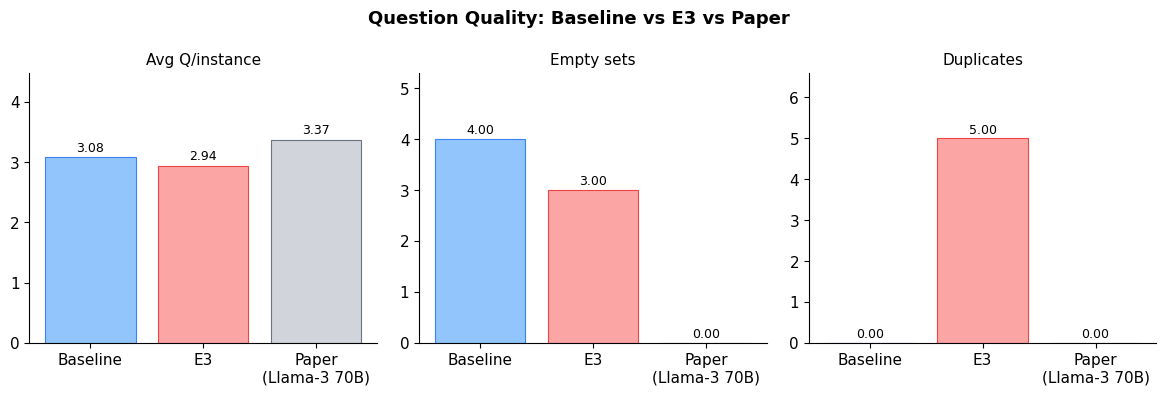

Saved: plot_question_quality.png


In [102]:
# Cell [63]: Plot question quality
# PLOT: Question Quality Comparison — Baseline vs E3
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

metrics = ["Avg Q/instance", "Empty sets", "Duplicates"]
base_vals = [base_stats["avg_q"], base_stats["empty"], base_stats["duplicates"]]
e3_vals_plot = [e3_stats["avg_q"], e3_stats["empty"], e3_stats["duplicates"]]
paper_vals = [3.37, 0, 0]

x = np.arange(len(metrics))
width = 0.25

for i, (metric, bv, ev, pv) in enumerate(zip(metrics, base_vals, e3_vals_plot, paper_vals)):
    ax = axes[i]
    bars = ax.bar(["Baseline", "E3", "Paper\n(Llama-3 70B)"],
                  [bv, ev, pv],
                  color=["#93c5fd", "#fca5a5", "#d1d5db"],
                  edgecolor=["#3b82f6", "#ef4444", "#6b7280"],
                  linewidth=0.8)
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    ax.set_title(metric, fontsize=11)
    ax.set_ylim(0, max(bv, ev, pv) * 1.3 + 0.1)

plt.suptitle("Question Quality: Baseline vs E3 vs Paper", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(REPO_ROOT, "results", "contratico", "e3", "plot_question_quality.png"), dpi=150)
plt.show()
print("Saved: plot_question_quality.png")

---
## Summary of E3 Results

### Setup
- **Model:** Qwen3-4B (17× smaller than paper's Llama-3 70B)
- **Dataset:** CONTRATICO EN-ES and EN-FR, 500 instances, 4 perturbation types
- **Baseline:** atomic pipeline | **Extension:** factcoverage (E3) pipeline

### 1. Baseline Fact Coverage = 87.5%
The baseline atomic prompt covers 87.5% of entailed facts (SBERT cosine ≥ 0.7). E3 raises this to 95.8%. 377/497 instances already had 100% coverage, but 106 instances had <80% — confirming a real gap for E3 to address.

### 2. E3 Improves F1 on Minor Perturbations, Not Critical

| | EN-ES | | EN-FR | |
|---|---|---|---|---|
| **Perturbation** | **Baseline F1** | **E3 F1 (Δ)** | **Baseline F1** | **E3 F1 (Δ)** |
| synonym | 0.767 | 0.842 (+0.075) | 0.781 | 0.856 (+0.075) |
| expansion | 0.790 | 0.862 (+0.072) | 0.790 | 0.872 (+0.082) |
| omission | 0.673 | 0.715 (+0.042) | 0.657 | 0.695 (+0.038) |
| alteration | 0.444 | 0.444 (-0.001) | 0.438 | 0.413 (-0.025) |

E3 consistently improves Minor perturbations by +0.07–0.08 F1 across both languages. Critical detection is unchanged. Results are remarkably consistent across EN-ES and EN-FR.

### 3. EM Improvements Are Even Larger (+0.10 to +0.19)
Per-fact questions produce more focused, deterministic answers. EM gains of +0.18 on synonym/expansion show answers match exactly far more often.

### 4. E3 Widens the Minor-Critical Gap
- EN-ES: 0.220 → 0.273 (+24%)
- EN-FR: 0.238 → 0.310 (+30%)

Better severity discrimination — E3 more clearly separates acceptable from problematic translations.

### 5. Instance-Level Pearson Correlation Improves

| Dataset | Metric | Baseline r | E3 r | Improvement |
|---------|--------|-----------|------|-------------|
| EN-ES | F1 vs xCOMET | 0.392 | 0.431 | +10% |
| EN-ES | EM vs xCOMET | 0.279 | 0.348 | +25% |
| EN-FR | F1 vs xCOMET | 0.389 | 0.455 | +17% |
| EN-FR | EM vs xCOMET | 0.273 | 0.367 | +34% |

All correlations computed at instance level (n ≈ 1920). E3 aligns better with established QE metrics, especially for EM.

### 6. Silhouette Scores Confirm Better Severity Discrimination

| Pipeline | EN-ES F1 | EN-FR F1 |
|----------|---------|---------|
| vanilla | 0.045 | 0.056 |
| atomic | 0.116 | 0.131 |
| **factcoverage** | **0.173** | **0.210** |
| xCOMET (reference) | 0.204 | 0.222 |

E3 silhouette approaches xCOMET levels — a strong result for a reference-free method.

### 7. Mismatch Fraction Shows Clean Severity Staircase (E3, EN-ES)
- synonym: 40% | expansion: 37% | omission: 63% | alteration: 87%

Baseline mismatch was higher across the board (67%/66%/77%/93%), meaning it flagged too many acceptable translations. E3 reduces false alarms by ~26 percentage points on Minor perturbations while maintaining sensitivity to Critical errors.

### 8. Question Quality Is Comparable
- E3: 2.94 Q/instance vs baseline 3.08 (ratio 0.96×)
- 3 empty sets (vs 4 baseline), 5 duplicates (vs 0 baseline) — negligible
- 100% of instances achieved 1:1 fact-to-question mapping in single call (no fallback needed)

### Interpretation
E3 does **not** improve severe error detection — both methods catch alteration and omission equally. E3's value is in **precision**: per-fact questions produce more consistent answers for acceptable translations, reducing false rejections and widening the severity gap. The mechanism is primarily **question specificity** rather than fact coverage, since baseline coverage was already 87.5%.

### Limitations
- 4 of 8 perturbation types (no spelling, word_order, intensifier, expansion_impact)
- 2 of 5 language pairs (missing EN-HI, EN-TL, EN-ZH)
- Qwen3-4B vs paper's Llama-3 70B — results may differ with larger models
- No evaluation on BioMQM (naturally occurring errors)
- E3 fact coverage reached 95.8% not 100% — SBERT threshold may need tuning


### 5f. Save E3 Results

In [142]:
# Cell [66]: Save E3 results — both languages
results_dir = os.path.join(REPO_ROOT, "results", "contratico", "e3")
os.makedirs(results_dir, exist_ok=True)

LANGUAGES = ["es", "fr"]

for lang in LANGUAGES:
    e3_lang = all_e3_scores.get(lang, {})
    base_lang = all_baseline_scores.get(lang, {})

    e3_results = {
        "dataset": f"CONTRATICO EN-{lang.upper()}",
        "model": "Qwen3-4B",
        "variant": "factcoverage (E3)",
        "baseline_coverage": {
            "mean": float(np.mean(coverage_rates)),
            "median": float(np.median(coverage_rates)),
            "threshold": COVERAGE_THRESHOLD,
        },
        "perturbation_scores": {},
        "question_quality": e3_stats,
        "qg_time_seconds": e3_qg_time,
    }

    for pert in PERTURBATIONS:
        entry = {}
        e = e3_lang.get(pert, {})
        b = base_lang.get(pert, {})
        entry["e3_f1"] = e.get("f1", None)
        entry["e3_em"] = e.get("em", None)
        entry["baseline_f1"] = b.get("f1", None)
        entry["baseline_em"] = b.get("em", None)
        if entry["e3_f1"] is not None and entry["baseline_f1"] is not None:
            entry["delta_f1"] = entry["e3_f1"] - entry["baseline_f1"]
        e3_results["perturbation_scores"][pert] = entry

    output_file = os.path.join(results_dir, f"contratico-e3-scores-en-{lang}.json")
    with open(output_file, "w") as f:
        json.dump(e3_results, f, indent=2)
    print(f"EN-{lang.upper()} results saved to {output_file}")

EN-ES results saved to /content/drive/MyDrive/CucumBERT_askqe/results/contratico/e3/contratico-e3-scores-en-es.json
EN-FR results saved to /content/drive/MyDrive/CucumBERT_askqe/results/contratico/e3/contratico-e3-scores-en-fr.json
